In [1]:
%matplotlib notebook

import tkinter
import matplotlib
import platform
if platform.system() not in ['Linux', 'Darwin'] and not platform.system().startswith('CYGWIN'):
    matplotlib.use('TKAgg')
import matplotlib.pyplot as plt
from IPython import display


# 鑑黃大師 (pytorch)

In [2]:
import glob
import os
import cv2
os.environ['TRIDENT_BACKEND'] = 'pytorch'
#!pip install tridentx --upgrade
import trident as T
from trident import *

trident 0.3.7
Using Pytorch backend.
Image Data Format: channels_first.
Image Channel Order: rgb.
Using pillow image backend.
Pillow version:6.2.1.
Pytorch version:1.3.1.


![Alt text](../images/porndetector.jpg)

![Alt text](../images/pornclass.jpg)

In [3]:
dataset=load_examples_data('nsfw')
dataset.image_transform_funcs=[
    random_adjust_gamma(gamma=(0.8,1.2)),
    #隨機調整圖片明暗gamma 0.6~1.4之間
    random_adjust_contast(scale=(0.8, 1.2)),
    #隨機調整圖片對比度
    random_adjust_hue(),
    #隨機調整色相
    add_noise(intensity=np.random.choice(np.arange(0.001,0.1,0.0005))),
    #隨機加入噪音
    random_center_crop(224,224,scale=(0.9,1.1)),
    normalize(0, 255),  
    normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]

#數據集的圖片處理流程image_transform_funcs為標準imagenet標準化
#加上隨機調整色相random_adjust_hue以及隨機等比例縮放中心裁切random_center_crop

archive file is already existing, donnot need download again.
extraction is finished, donnot need extract again.
training images: 10001  test images:5746
Mapping class_names  in en-us   success, total 5 class names added.
Mapping class_names  in zh-tw   success, total 5 class names added.
Mapping class_names  in zh-cn   success, total 5 class names added.


![Alt text](../images/nsfw_data.jpg)

![Alt text](../images/EfficientNet.jpg)

In [4]:
#獲取EfficientNet-B0預訓練模型
#將全連接層長度改為5
effb0=EfficientNetB0(include_top=True,
             pretrained=True,
             input_shape=(3,224,224),
             classes=5)

#只開放全連接層以及最後一組Efficient Block開放學習
effb0.model.trainable=False
effb0.model.fc.trainable=True
effb0.model.block7a.trainable=True


archive file is already existing, donnot need download again.
4013953 parameters have set untrainable
6405 parameters have set trainable
717232 parameters have set trainable


In [5]:
#召回率
def recall(output,target):
    input_tensor=output.clone().detach()
    target_tensor=target.clone().detach()
    input_tensor=argmax(input_tensor,1).squeeze() #將預測結果透過argmax，產生類別的判斷
    input_tensor=input_tensor.eq(3).float() #檢查那些預測結果是3(色情圖片)
    target_tensor=target_tensor.eq(3).float() #檢查那些答案是3(色情圖片)
    return (input_tensor*target_tensor).sum()/max(target_tensor.sum(),1)
#input_tensor*target_tensor兩個相乘結果為1，則表示實際是色情圖片且正確被預測
#除以所有的色情圖片總數target_tensor.sum()就可以獲得召回率

In [6]:
class CustomCallback(CallbackBase):
    def __init__(self):
        super(CustomCallback, self).__init__()
    def on_epoch_start(self, training_context):
        if training_context['current_epoch']==2:
            training_context['current_model'].block6d.trainable=True #透過training_context切換模型指定層的trainable狀態
        if training_context['current_epoch']==5:
            training_context['current_model'].block6c.trainable=True #透過training_context切換模型指定層的trainable狀態
        if training_context['current_epoch']==8:
            training_context['current_model'].block6b.trainable=True #透過training_context切換模型指定層的trainable狀態
    

In [7]:
effb0=effb0\
    .with_optimizer(optimizer='Ranger',lr=1e-3,betas=(0.9, 0.999))\
    .with_loss(CrossEntropyLoss)\
    .with_loss(F1ScoreLoss,name='f1_score')\
    .with_metric(accuracy,name='accuracy')\
    .with_metric(recall,name='recall')\
    .with_regularizer('l2')\
    .with_constraint('max_min_norm')\
    .with_model_save_path('Models/effb0.pth')\
    .with_learning_rate_scheduler(reduce_lr_on_plateau,monitor='accuracy',mode='max',factor=0.5,patience=3,cooldown=2,threshold=5e-5,warmup=0)\
    .with_callbacks(CustomCallback())

#指定優化器(使用Ranger)
#設定損失函數(交叉熵)
#設定評估函數(正確率與召回率)
#設定l2正則化
#設定max_min_norm權重約束
#指定模型存檔位置
#指定學習速率調整機制


effb0.summary()
#檢視模型結構

--------------------------------------------------------------------------------------------------------------------------------
                            Layer (type)                   Output Shape                    Weight Shape      Bias Shape          Param #          FLOPS #
                                    stem             [-1, 32, 112, 112]                                                                0              0.0
                            batch_norm_1             [-1, 32, 112, 112]                            [32]            [32]               64      1,191,680.0
                               conv2d_79             [-1, 32, 112, 112]                   [32, 1, 3, 3]                              288      7,212,800.0
                      depthwise_conv2d_1             [-1, 32, 112, 112]                                                                0              0.0
                            batch_norm_2             [-1, 32, 112, 112]                            [3

                           batch_norm_34              [-1, 672, 14, 14]                           [672]           [672]            1,344        394,940.0
                               conv2d_90                [-1, 672, 7, 7]                  [672, 1, 5, 5]                           16,800      1,646,351.0
                     depthwise_conv2d_12                [-1, 672, 7, 7]                                                                0              0.0
                           batch_norm_35                [-1, 672, 7, 7]                           [672]           [672]            1,344         98,735.0
                          block6a_dwconv                [-1, 672, 7, 7]                                                                0              0.0
               squeeze_excite_12_squeeze                 [-1, 28, 1, 1]                 [28, 672, 1, 1]            [28]           18,844         37,659.0
                squeeze_excite_12_excite                [-1, 672, 1, 1]     

In [8]:
#設定學習計畫
#指定資料提供者
#跑10個epoach
#minibatch_size為16
#每10個批次列印一次訓練進度
#每100個批次顯示一次loss_metric_curve
#每10個批次存檔一次
plan=TrainingPlan()\
    .add_training_item(effb0)\
    .with_data_loader(dataset)\
    .repeat_epochs(10)\
    .within_minibatch_size(16)\
    .print_progress_scheduling(20,unit='batch')\
    .display_loss_metric_curve_scheduling(frequency=100,unit='batch',imshow=True)\
    .save_model_scheduling(10,unit='batch')

model 0          Step: 13s865ms | Loss: 3.859   | Accuracy: 69.062% ,Recall: 87.707%  | learning rate: 9.766e-07 | epoch: 8 ( 600/626 )


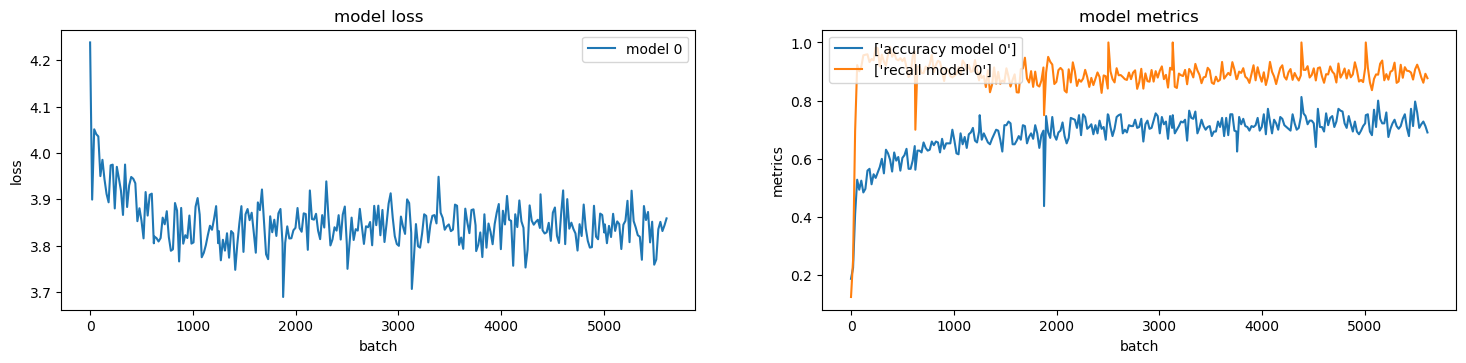

model 0          Step: 16s36ms  | Loss: 3.844   | Accuracy: 70.312% ,Recall: 90.190%  | learning rate: 9.766e-07 | epoch: 8 ( 620/626 )
model 0          Step: 4s209ms  | Loss: 3.775   | Accuracy: 75.000% ,Recall: 85.714%  | learning rate: 9.766e-07 | epoch: 9 ( 0/626 )
model 0          Step: 14s87ms  | Loss: 3.814   | Accuracy: 71.875% ,Recall: 87.083%  | learning rate: 9.766e-07 | epoch: 9 ( 20/626 )
model 0          Step: 13s813ms | Loss: 3.858   | Accuracy: 73.125% ,Recall: 88.077%  | learning rate: 9.766e-07 | epoch: 9 ( 40/626 )
model 0          Step: 14s667ms | Loss: 3.863   | Accuracy: 73.750% ,Recall: 95.192%  | learning rate: 9.766e-07 | epoch: 9 ( 60/626 )
model 0          Step: 15s613ms | Loss: 3.823   | Accuracy: 69.375% ,Recall: 87.320%  | learning rate: 9.766e-07 | epoch: 9 ( 80/626 )
model 0          Step: 14s319ms | Loss: 3.808   | Accuracy: 71.562% ,Recall: 86.676%  | learning rate: 9.766e-07 | epoch: 9 ( 100/626 )


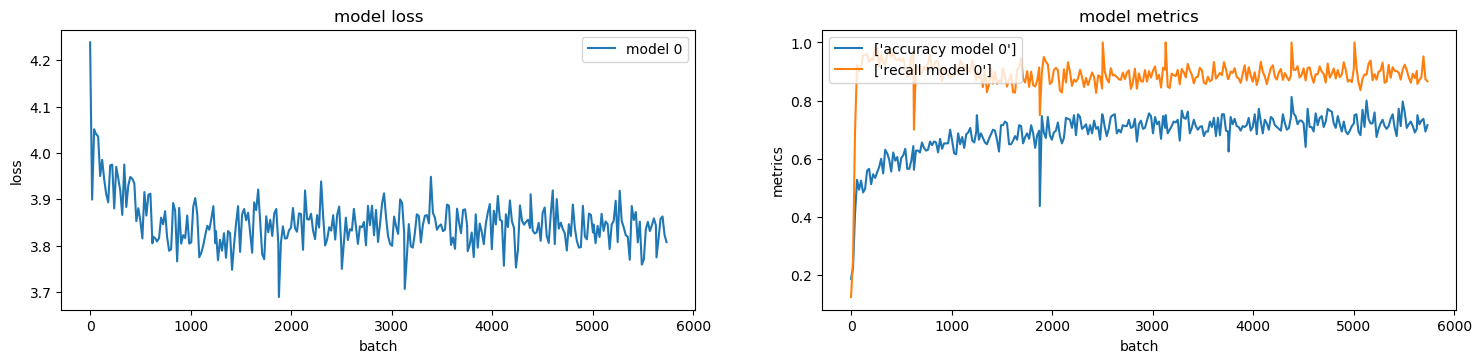

model 0          Step: 16s941ms | Loss: 3.852   | Accuracy: 70.312% ,Recall: 90.407%  | learning rate: 9.766e-07 | epoch: 9 ( 120/626 )
model 0          Step: 15s717ms | Loss: 3.797   | Accuracy: 72.812% ,Recall: 89.192%  | learning rate: 9.766e-07 | epoch: 9 ( 140/626 )
model 0          Step: 15s796ms | Loss: 3.831   | Accuracy: 70.000% ,Recall: 88.591%  | learning rate: 9.766e-07 | epoch: 9 ( 160/626 )
model 0          Step: 15s215ms | Loss: 3.821   | Accuracy: 75.625% ,Recall: 90.452%  | learning rate: 9.766e-07 | epoch: 9 ( 180/626 )
model 0          Step: 16s9ms   | Loss: 3.879   | Accuracy: 72.812% ,Recall: 89.629%  | learning rate: 9.766e-07 | epoch: 9 ( 200/626 )
learning rate changed! ( form 9.766e-07 to 4.883e-07)

Epoch 00009: ReduceLROnPlateau reducing learning rate to 4.8828125e-07.


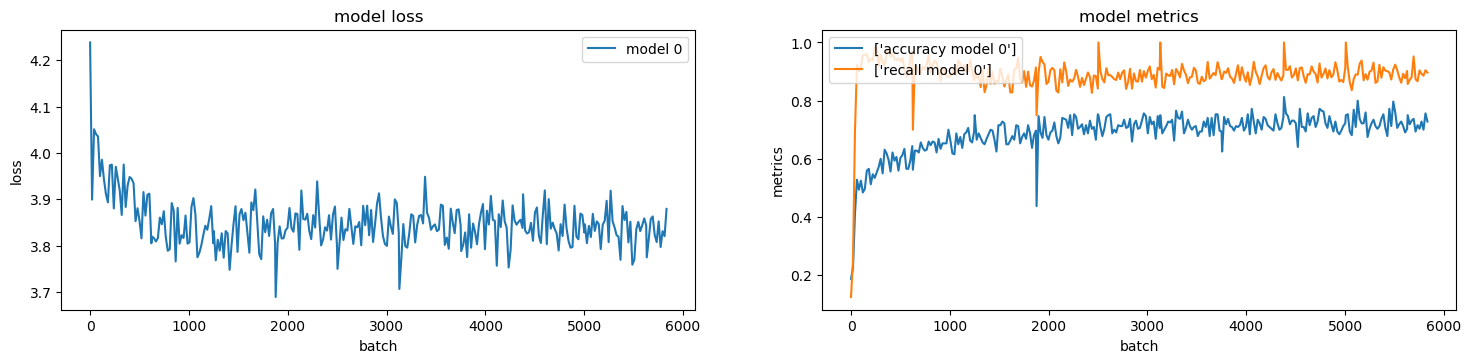

model 0          Step: 15s453ms | Loss: 3.841   | Accuracy: 74.688% ,Recall: 87.863%  | learning rate: 4.883e-07 | epoch: 9 ( 220/626 )
model 0          Step: 14s181ms | Loss: 3.804   | Accuracy: 74.688% ,Recall: 93.571%  | learning rate: 4.883e-07 | epoch: 9 ( 240/626 )
model 0          Step: 14s238ms | Loss: 3.931   | Accuracy: 70.000% ,Recall: 88.592%  | learning rate: 4.883e-07 | epoch: 9 ( 260/626 )
model 0          Step: 14s339ms | Loss: 3.844   | Accuracy: 72.812% ,Recall: 86.162%  | learning rate: 4.883e-07 | epoch: 9 ( 280/626 )
model 0          Step: 14s616ms | Loss: 3.794   | Accuracy: 69.375% ,Recall: 87.482%  | learning rate: 4.883e-07 | epoch: 9 ( 300/626 )


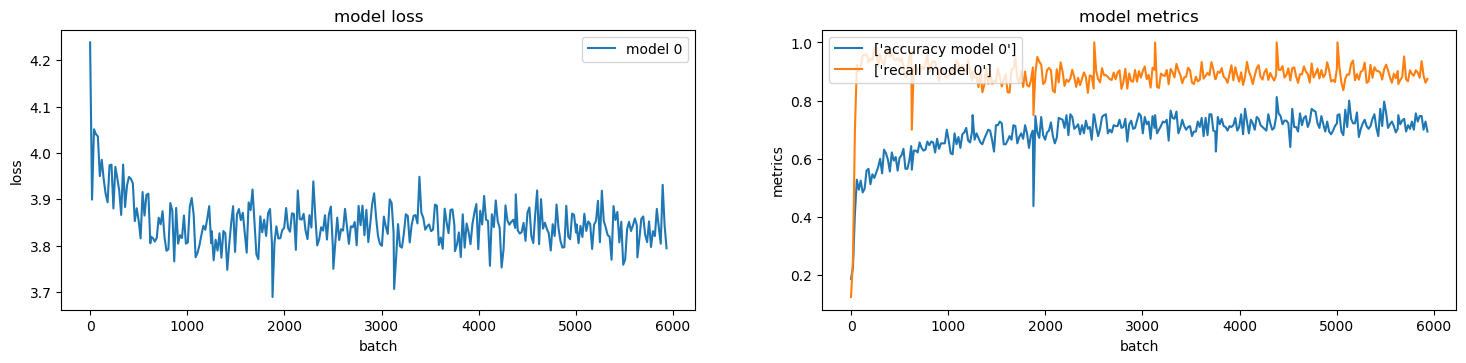

model 0          Step: 15s320ms | Loss: 3.832   | Accuracy: 69.062% ,Recall: 85.472%  | learning rate: 4.883e-07 | epoch: 9 ( 320/626 )
model 0          Step: 14s973ms | Loss: 3.832   | Accuracy: 72.812% ,Recall: 90.567%  | learning rate: 4.883e-07 | epoch: 9 ( 340/626 )
model 0          Step: 14s517ms | Loss: 3.810   | Accuracy: 72.188% ,Recall: 92.599%  | learning rate: 4.883e-07 | epoch: 9 ( 360/626 )
model 0          Step: 15s131ms | Loss: 3.854   | Accuracy: 70.625% ,Recall: 87.805%  | learning rate: 4.883e-07 | epoch: 9 ( 380/626 )
model 0          Step: 15s265ms | Loss: 3.863   | Accuracy: 71.250% ,Recall: 85.661%  | learning rate: 4.883e-07 | epoch: 9 ( 400/626 )


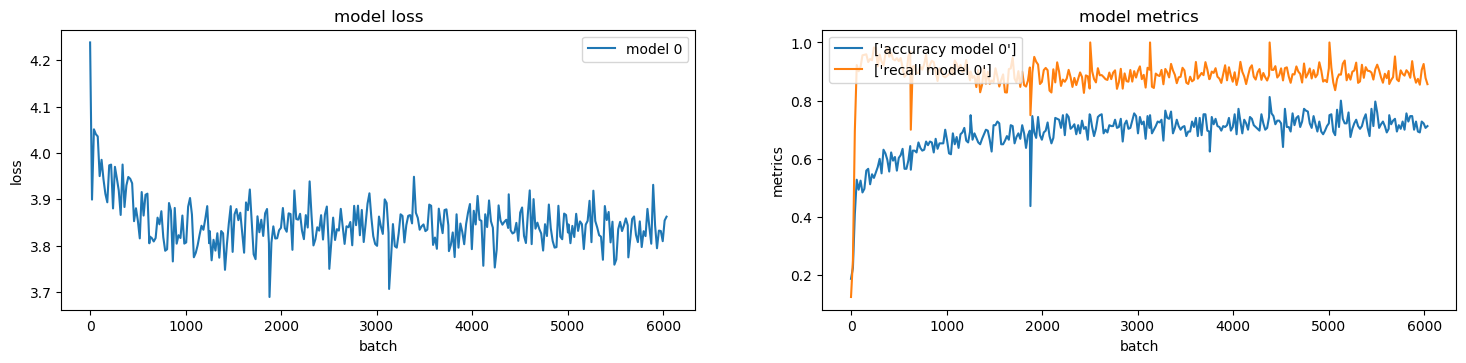

model 0          Step: 14s789ms | Loss: 3.869   | Accuracy: 74.688% ,Recall: 90.314%  | learning rate: 4.883e-07 | epoch: 9 ( 420/626 )
model 0          Step: 14s36ms  | Loss: 3.843   | Accuracy: 69.062% ,Recall: 88.070%  | learning rate: 4.883e-07 | epoch: 9 ( 440/626 )
model 0          Step: 13s733ms | Loss: 3.836   | Accuracy: 73.750% ,Recall: 90.122%  | learning rate: 4.883e-07 | epoch: 9 ( 460/626 )
model 0          Step: 13s718ms | Loss: 3.846   | Accuracy: 74.688% ,Recall: 93.192%  | learning rate: 4.883e-07 | epoch: 9 ( 480/626 )
model 0          Step: 13s482ms | Loss: 3.795   | Accuracy: 73.750% ,Recall: 89.849%  | learning rate: 4.883e-07 | epoch: 9 ( 500/626 )


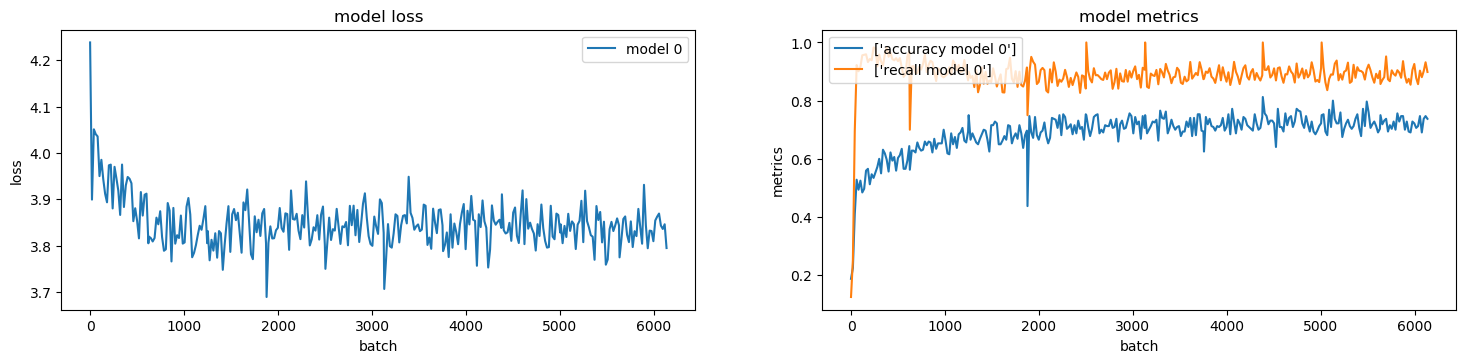

model 0          Step: 14s597ms | Loss: 3.843   | Accuracy: 68.750% ,Recall: 84.348%  | learning rate: 4.883e-07 | epoch: 9 ( 520/626 )
model 0          Step: 14s182ms | Loss: 3.765   | Accuracy: 76.875% ,Recall: 92.597%  | learning rate: 4.883e-07 | epoch: 9 ( 540/626 )
model 0          Step: 13s548ms | Loss: 3.826   | Accuracy: 75.312% ,Recall: 91.523%  | learning rate: 4.883e-07 | epoch: 9 ( 560/626 )
model 0          Step: 13s567ms | Loss: 3.846   | Accuracy: 73.438% ,Recall: 83.956%  | learning rate: 4.883e-07 | epoch: 9 ( 580/626 )
model 0          Step: 13s593ms | Loss: 3.879   | Accuracy: 69.375% ,Recall: 89.573%  | learning rate: 4.883e-07 | epoch: 9 ( 600/626 )
learning rate changed! ( form 4.883e-07 to 2.441e-07)

Epoch 00009: ReduceLROnPlateau reducing learning rate to 2.44140625e-07.


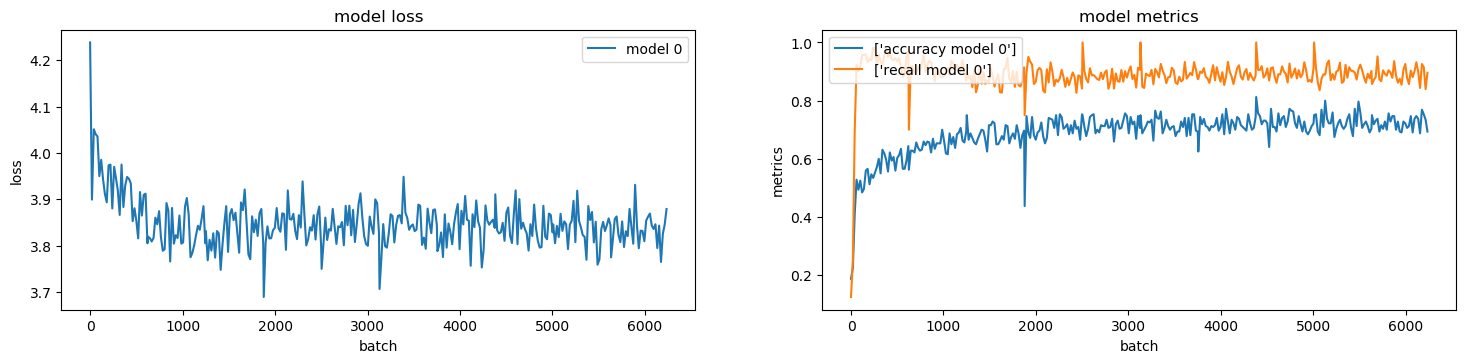

model 0          Step: 14s871ms | Loss: 3.837   | Accuracy: 71.562% ,Recall: 87.235%  | learning rate: 2.441e-07 | epoch: 9 ( 620/626 )


In [9]:
#執行訓練
plan.start_now()

In [10]:
effb0.class_names=dataset.class_names['zh-tw']

OrderedDict([('中性', (2, 0.25072503)), ('繪畫', (0, 0.24936557)), ('性感', (4, 0.17177434))])


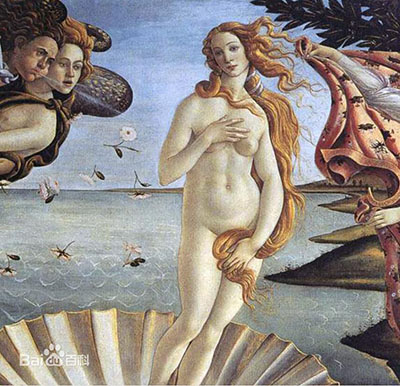

In [11]:
img=read_image('../images/venus.jpg')
print(effb0.infer_single_image('../images/venus.jpg',3))
img

OrderedDict([('中性', (2, 0.29352614)), ('性感', (4, 0.20197181)), ('繪畫', (0, 0.18262827))])


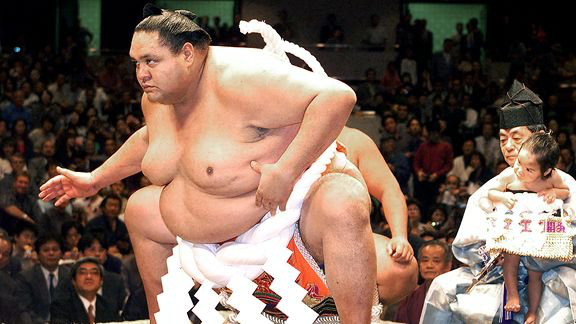

In [12]:
img=read_image('../images/sumo.jpg')
print(effb0.infer_single_image('../images/sumo.jpg',3))
img

OrderedDict([('性感', (4, 0.23544894)), ('中性', (2, 0.2251634)), ('色情漫畫', (1, 0.19345337))])


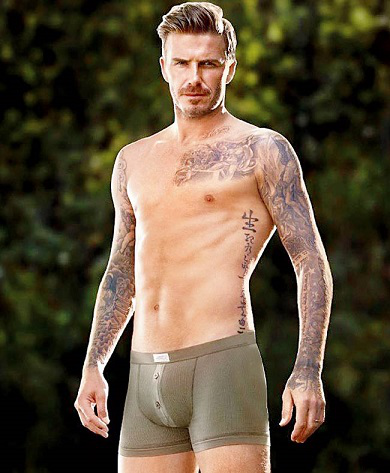

In [13]:
img=read_image('../images/beckham.jpg')
print(effb0.infer_single_image('../images/beckham.jpg',3))
img

OrderedDict([('繪畫', (0, 0.3253861)), ('性感', (4, 0.17964143)), ('中性', (2, 0.16991764))])


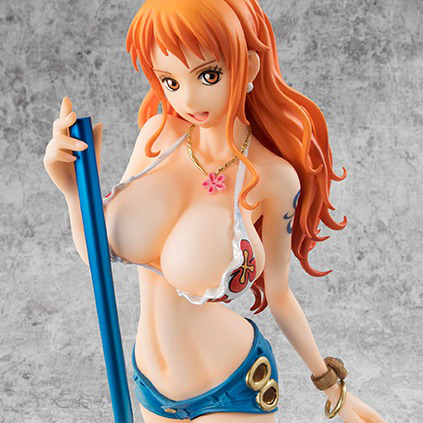

In [14]:
img=read_image('../images/nami.jpg')
print(effb0.infer_single_image('../images/nami.jpg',3))
img